## Index Model
The index model is an explanatory model relating the excess return of a stock to its sensitivity to the market's excess return. This is a simplification of the mean-variance optimization method (requires significantly less inputs) because positive covariances among security returns arise from common economic sources. We can simplify the estimation of the covariance matrix by decomposing risk into systematic and unique components. This is a *single factor* model because the broad market index is a proxy for the common factor impacting all stock returns. While beneficial to observe, there are obvious and inherent limitations that will be explored. In this notebook, I will examine Google's (GOOG) beta, using the S&P 500 index as a proxy for the market. 

In [165]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf

# For model specification
from ISLP.models import ModelSpec as MS

# Settings
plt.style.use('Solarize_Light2')

### 1. Download Historical Data

[*********************100%***********************]  3 of 3 completed


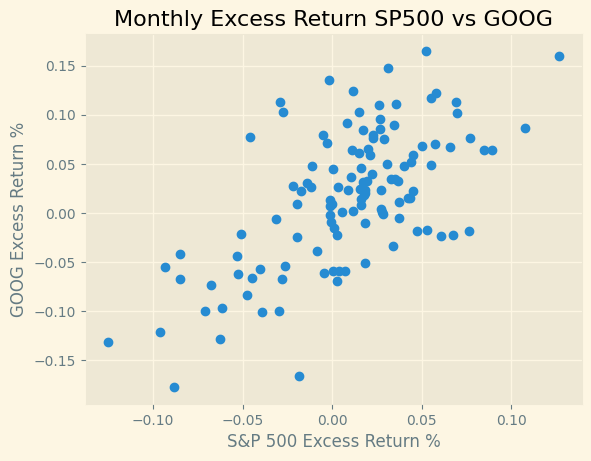

Ticker        GOOG       ^GSPC        ^IRX  ^GSPC_excess  GOOG_excess
count   119.000000  119.000000  119.000000    119.000000   119.000000
mean      0.018300    0.010512    0.001796      0.008716     0.016505
std       0.069369    0.043788    0.001660      0.043757     0.069342
min      -0.176750   -0.125119    0.000002     -0.125144    -0.177421
25%      -0.020789   -0.010517    0.000226     -0.013024    -0.022958
50%       0.023956    0.017859    0.001324      0.015718     0.022002
75%       0.068205    0.035692    0.003793      0.034873     0.066208
max       0.165080    0.126844    0.004329      0.126769     0.165078


In [166]:
# Download closing data
# NOTE: the 13-week T-bill is a proxy for the risk free rate, as the 1M T-bill rate is not available from Yahoo Finance
tickers = ['^GSPC', 'GOOG', '^IRX']
data = yf.download(tickers, period='10y', interval='1mo', auto_adjust=True)['Close']

# Convert interest rate to monthly basis
# Deal with missing interest rates with forward fill
data['^IRX'] = data['^IRX'] / 100
data['^IRX'] = (1 + data['^IRX']) ** (1 / 12) - 1
data['^IRX'] = data['^IRX'].ffill()

# Calculate the monthly return
data[['^GSPC', 'GOOG']] = data[['^GSPC', 'GOOG']].pct_change()

# Calculate excess returns
data['^GSPC_excess'] = data['^GSPC'] - data['^IRX']
data['GOOG_excess'] = data['GOOG'] - data['^IRX']

data.dropna(inplace=True)

# Create a scatter plot
plt.scatter(data['^GSPC_excess'], data['GOOG_excess'])
plt.title('Monthly Excess Return SP500 vs GOOG')
plt.xlabel('S&P 500 Excess Return %')
plt.ylabel('GOOG Excess Return %')
plt.show()

print(data.describe())

### 2. Create the Index Model
The index model can be formed using the following regression equation:<br><br>
$R_i(t)=\alpha_i+\beta_i*R_m(t)+\epsilon_i(t)$<br>
$\alpha_i$ - intercept of the regression equation; security's excess return when the market excess return is 0<br>
$\beta_i$ - slope of the regression line; amount by which the security return tends to increase/decrease for every 1% change in the index<br>
$\epsilon_i$ - firm-specific surprise in month *t*; residuals<br>
$R_i(t)$ - excess return of security *i* in month *t*<br>
$R_m(t)$ - excess return of market index in month *t*<br>

In [167]:
X = MS(['^GSPC']).fit_transform(data)
y = data['GOOG']

# Create the index model
index_model = sm.OLS(y, X)
results = index_model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   GOOG   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     81.13
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           4.71e-15
Time:                        16:57:36   Log-Likelihood:                 180.52
No. Observations:                 119   AIC:                            -357.0
Df Residuals:                     117   BIC:                            -351.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0076      0.005      1.514      0.1

From the regression results, we can see that the beta ($\beta_{GOOG}$) is 1.012. This means, for every 1% change in the market index we can expect, on average, for Google to change by approximately 1.012%. The intercept suggests that in a neutral market (when the the excess return of the market is 0%), we can expect Google's excess return to be 0.0076%, on average. The ~0.0 p-value of the beta coefficient is statistically significant, suggesting that the market factor explains the variation in the stock's return. The ~0.13 p-value of the intercept is not statistically significant, suggesting that there is no evidence of a persistent abnormal return after adjusting for market exposure. The $R^{2}$ of 0.409 means that ~41% of the variation of Google's returns are explained by the market.<br>
Logically speaking, these results are intuitive. Google is a large company, and has been a significant contributor to the performance of the overall market.

### Static Residual Statistics
The section below further analyzes the model's residuals.

Index Model RSE:        0.0538
Index Model Pct. Error: 77.8330%
Residual Mean:          -0.0000
Residual Skewness:      0.1502
Residual Kurtosis:      0.2092


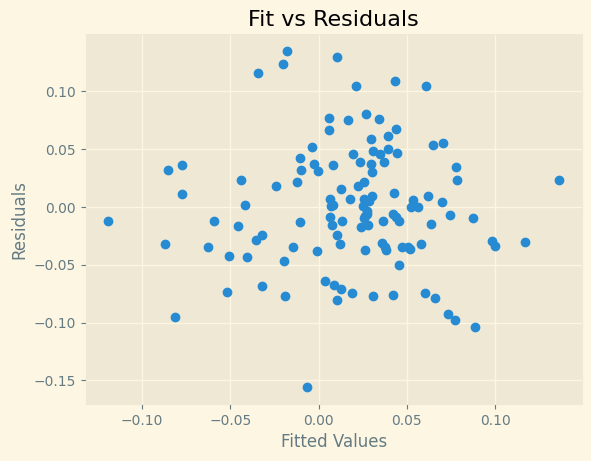

In [168]:
n = len(y)
p = X.shape[1] # Number of model parameters

RSS = sum(results.resid ** 2)       # Residual sum of squares
RSE = np.sqrt(RSS / (n - p - 1))    # Residual standard error
pct_error = (RSE / np.std(y)) * 100 # Percentage error

# Residual statistics
resid_mean = np.mean(results.resid)
resid_skew = st.skew(results.resid)
resit_kurt = st.kurtosis(results.resid)

# Print the model statistics
print(f'Index Model RSE:        {RSE:.4f}')
print(f'Index Model Pct. Error: {pct_error:.4f}%')
print(f'Residual Mean:          {resid_mean:.4f}')
print(f'Residual Skewness:      {resid_skew:.4f}')
print(f'Residual Kurtosis:      {resit_kurt:.4f}')

# Plot the fitted values against the residuals
plt.scatter(results.fittedvalues, results.resid)
plt.title('Fit vs Residuals')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Shapiro-Wilk Test (stat): 0.9883
Shapiro-Wilk Test (pval): 0.4008


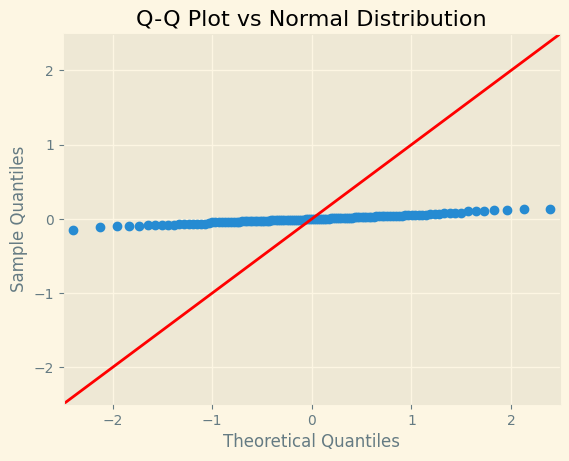

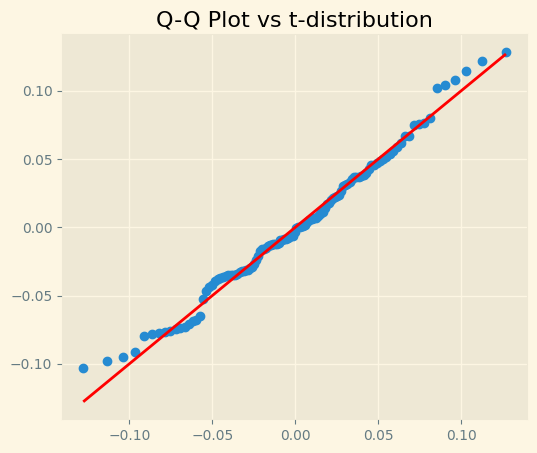

In [169]:
# Shapiro-Wilk test
shapiro_test = st.shapiro(results.resid)
print(f"Shapiro-Wilk Test (stat): {shapiro_test[0]:.4f}")
print(f"Shapiro-Wilk Test (pval): {shapiro_test[1]:.4f}")

# Q-Q plot of residuals (normal distribution)
sm.qqplot(results.resid, line='45')
plt.title(f"Q-Q Plot vs Normal Distribution")
plt.show()

# Q-Q plot of residuals (t-distribution)
df, loc, scale = st.t.fit(results.resid)
theoretical_q = st.t.ppf(np.linspace(0.01, 0.99, len(results.resid)), df, loc, scale)
sample_q = np.quantile(results.resid, np.linspace(0.01, 0.99, len(results.resid)))

plt.figure(figsize=(6, 5))
plt.scatter(theoretical_q, sample_q)
plt.plot(theoretical_q, theoretical_q, 'r')  # 45 deg reference line
plt.title(f"Q-Q Plot vs t-distribution")
plt.show()